# Covid-19 and H1N1 Effects on US Unemployment

In [10]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from ipywidgets import *
import warnings;
warnings.filterwarnings('ignore');

### Data Cleanup

In [11]:
#UnempUpdated (incuded in githup repo) is a semi cleaned version of the unemployment data in BLS

df = pd.read_csv("UnempUpdated.csv")
df = df.rename(columns={"Year ":"Year"})
# DC, Los Angeles County, and New York City is included, drop these rows
drop = df[df["State and area"] != "Los Angeles County"]
drop = drop[drop["State and area"] != "New York city"]
df = drop[drop["State and area"] != "District of Columbia"]
df = df.drop(columns=["Unemployment Total"])
df

,State and area,Year,Month,Civilian non-institutional population,Civilian labor force,Percent of population,Total,Percent of population.1,Rate
0,Alabama,1976,1,2605000.0,1479554.0,56.8,1362852.0,52.3,7.9
1,Alaska,1976,1,232000.0,153109.0,66.0,138852.0,59.8,9.3
2,Arizona,1976,1,1621000.0,959530.0,59.2,847058.0,52.3,11.7
3,Arkansas,1976,1,1536000.0,857544.0,55.8,781080.0,50.9,8.9
4,California,1976,1,15621000.0,9686520.0,62.0,8689249.0,55.6,10.3
...,...,...,...,...,...,...,...,...,...
28403,Virginia,2020,8,6715430.0,4348190.0,64.7,4073362.0,60.7,6.3
28404,Washington,2020,8,6114953.0,3963255.0,64.8,3630085.0,59.4,8.4
28405,West Virginia,2020,8,1438628.0,772389.0,53.7,705328.0,49.0,8.7
28406,Wisconsin,2020,8,4659832.0,3062770.0,65.7,2876913.0,61.7,6.1


## Covid-19 

### Support Vector Regression by State and Year

In [12]:
def pred_by_state_andYr(state,year):
    newDf = df[df["State and area"] == state]
    X = newDf[newDf["Year"] != year].values
    y = newDf[newDf["Year"] == year].values
    
    x_features = X[:,2:8]
    x_target = X[:,8]
    y_features = y[:,2:8]
    y_target = y[:,8]
    x_target = np.array(x_target).reshape(-1,1)
    y_target = np.array(y_target).reshape(-1,1)
    

    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X = sc_X.fit_transform(x_features)
    y = sc_y.fit_transform(x_target)
    y2 = sc_y.fit_transform(y_target)
    x2 = sc_X.fit_transform(y_features)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    regressor = SVR(kernel = 'rbf',C = 1, gamma = 0.01, epsilon = 0.1)
    regressor.fit(X_train,y_train)
    y_pred = regressor.predict(x2)
    y_pred = sc_y.inverse_transform(y_pred)
    plt.plot(y_features[:,0],y_pred,label = "Predicted")
    plt.plot(y_features[:,0],y_target,label="Actual")
    plt.legend()
    plt.xlabel("Month")
    plt.ylabel("Unemployment Rate")
    plt.xticks(np.arange(1, 13, step=1))
    plt.title("Pred vs Actual Unemployment Rate in " + state + " " + str(year))
    plt.show()
   
    
    return tuple((y_pred,sc_y.inverse_transform(y2)))
    

### SVR not effective in displaying difference due to Covids impact on the 2020 data

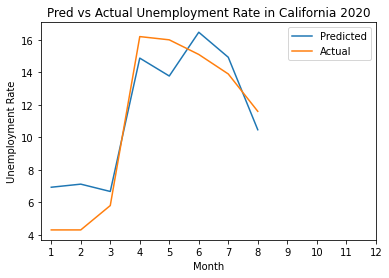

Mean Squared Error: 3.314366425963975


In [13]:
value = pred_by_state_andYr("California",2020)
print("Mean Squared Error: " + str(mean_squared_error(value[1],value[0])))


### 2020 covid impact using K nearest neighbors 

##### Using KNN, we can find the 3 nearest neighbors to the year of 2020, and output the mean unemployment rate of the 3 nearest neighbors. This will provide a better prediction for what the 2020 Unemployment rate would have been without covid

In [14]:
def graph_2020impact(state):
    newDf = df[df["State and area"] == state]
    X = newDf[newDf["Year"] != 2020].values
    y = newDf[newDf["Year"] == 2020].values
    x_features = X[:,2:8]
    x_target = X[:,8]
    y_features = y[:,2:8]
    y_target = y[:,8]
    
    
    neigh = KNeighborsRegressor(n_neighbors=3)
    neigh.fit(x_features,x_target)
    prediction = neigh.predict(y_features)
    
    plt.plot(y_features[:,0],prediction,label = "Predicted")
    plt.plot(y_features[:,0],y_target,label="Actual")
    plt.legend()
    plt.xlabel("Month")
    plt.ylabel("Unemployment Rate")
    plt.title("Impact of Covid in " + state +  " Unemployment Rate")
    plt.savefig(state + " covid impact")
    plt.show()
    print("Mean Squared Error: " + str(mean_squared_error(prediction,y_target)))
    

  

#### Widget

In [15]:
stateArray = df["State and area"]
stateArray = stateArray[0:50]

slider = interact(graph_2020impact,state =(stateArray)) 

interactive(children=(Dropdown(description='state', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Cali…

# H1N1 

### KNN Model for H1N1 (2009)

In [16]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
def graph_2009impact(state):
    newDf = df[df["Year"] != 2020]
    newDf = newDf[newDf["State and area"] == state]
    X = newDf[newDf["Year"] != 2009].values
    y = newDf[newDf["Year"] == 2009].values
    x_features = X[:,2:8]
    x_target = X[:,8]
    y_features = y[:,2:8]
    y_target = y[:,8]
    
    
    neigh = KNeighborsRegressor(n_neighbors=3)
    neigh.fit(x_features,x_target)
    prediction = neigh.predict(y_features)
    
    plt.plot(months,prediction,label = "Predicted")
    plt.plot(months,y_target,label="Actual")
    plt.legend(loc = "upper left")
    plt.xlabel("Month")
    plt.ylabel("Unemployment Rate")
    plt.ylim(0,32)
    plt.title(state,fontsize = 16, fontweight= "bold")
    plt.text(7,30,"Mean Squared Error: " + str(round(mean_squared_error(prediction,y_target),3)),fontsize=10)
    plt.savefig(state + " H1N1 impact")
    plt.xticks(months)
    plt.show()
    print("Mean Squared Error: " + str(mean_squared_error(prediction,y_target)))
    


#### Widget for H1N1

In [17]:
stateArray = df["State and area"]
stateArray = stateArray[0:50]


slider = interact(graph_2009impact,state =(stateArray)) 

interactive(children=(Dropdown(description='state', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Cali…

# Making graphs for the United States in General

### Data Cleanup

In [50]:
# Data Cleanup


start = 0
end = 50

UScnp = []
years = []
months = []
cvl = []
percPop = []
total = []
percPop1 = []
rate = []
country = []
for end in range(50,26850,50):
    value = 0
    partition = df[start:end]
    UScnp.append(partition["Civilian non-institutional population"].sum())
    years.append(partition["Year"].values)
    months.append(partition["Month"].values)
    cvl.append(partition["Civilian labor force"].sum())
    percPop.append((partition["Percent of population"].sum())/50)
    total.append(partition["Total"].sum())
    percPop1.append((partition["Percent of population.1"].sum())/50)
    rate.append((partition["Rate"].sum())/50)
    country.append("US")
    start += 50 

    
arr = []
currMonth = 1
for i in range(536):
    arr.append(currMonth)
    currMonth +=1
    if currMonth == 13:
        currMonth = 1
        
#arr = np.concatenate(arr)  
len(arr)

536

### Create new Dataframe with US totals

In [52]:
d = {"Area":country,"Year":years,"Month":arr,"Civilian non-institutional population":UScnp, \
     "Civilian labor force":cvl,"Percent of population":percPop,"Total":total,"Percent of population.1":percPop1, \
    "Rate":rate}
usDf = pd.DataFrame(data=d)
usDf

,Area,Year,Month,Civilian non-institutional population,Civilian labor force,Percent of population,Total,Percent of population.1,Rate
0,US,"[1976, 1976, 1976, 1976, 1976, 1976, 1976, 197...",1,153943000.0,93510926.0,61.428,85231152.0,56.298,8.352
1,US,"[1976, 1976, 1976, 1976, 1976, 1976, 1976, 197...",2,154200000.0,93702263.0,61.460,85557692.0,56.460,8.154
2,US,"[1976, 1976, 1976, 1976, 1976, 1976, 1976, 197...",3,154444000.0,94048631.0,61.604,86414322.0,56.932,7.616
3,US,"[1976, 1976, 1976, 1976, 1976, 1976, 1976, 197...",4,154691000.0,94335822.0,61.750,87379702.0,57.546,6.836
4,US,"[1976, 1976, 1976, 1976, 1976, 1976, 1976, 197...",5,154945000.0,94554692.0,61.948,88152449.0,58.052,6.292
...,...,...,...,...,...,...,...,...,...
531,US,"[2020, 2020, 2020, 2020, 2020, 2020, 2020, 202...",4,259316540.0,155426261.0,61.146,132966966.0,52.652,14.004
532,US,"[2020, 2020, 2020, 2020, 2020, 2020, 2020, 202...",5,259466728.0,157587949.0,61.662,137106989.0,54.214,12.164
533,US,"[2020, 2020, 2020, 2020, 2020, 2020, 2020, 202...",6,259624018.0,160486471.0,62.736,142450300.0,56.474,10.010
534,US,"[2020, 2020, 2020, 2020, 2020, 2020, 2020, 202...",7,259792118.0,160975013.0,62.876,144128456.0,57.056,9.316


### Covid Effects on Entire USA (2020)

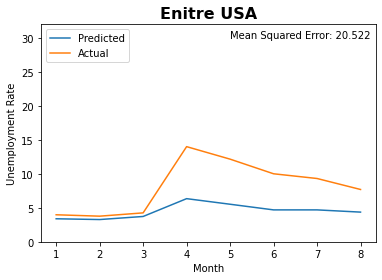

Mean Squared Error: 20.522431555555556


In [71]:
X = usDf[0:528].values
y = usDf[528:].values
x_features = X[:,2:8]
x_target = X[:,8]
y_features = y[:,2:8]
y_target = y[:,8]
    
    
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(x_features,x_target)
prediction = neigh.predict(y_features)
    
plt.plot(y_features[:,0],prediction,label = "Predicted")
plt.plot(y_features[:,0],y_target,label="Actual")
plt.legend(loc = "upper left")
plt.xlabel("Month")
plt.ylabel("Unemployment Rate")
plt.ylim(0,32)
plt.title("Enitre USA",fontsize = 16, fontweight= "bold")
plt.text(5,30,"Mean Squared Error: " + str(round(mean_squared_error(prediction,y_target),3)),fontsize=10)
plt.savefig("USA Graph")

plt.show()
print("Mean Squared Error: " + str(mean_squared_error(prediction,y_target)))  


### H1N1 Effects on Entire USA (2009)

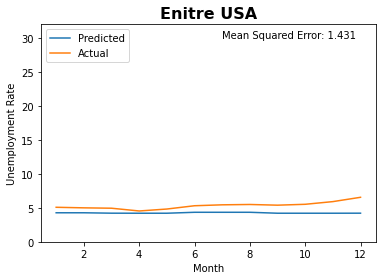

Mean Squared Error: 1.4314458148148148


In [72]:

X = usDf[0:384].values
y = usDf[384:396].values
x_features = X[:,2:8]
x_target = X[:,8]
y_features = y[:,2:8]
y_target = y[:,8]
    
    
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(x_features,x_target)
prediction = neigh.predict(y_features)
    
plt.plot(y_features[:,0],prediction,label = "Predicted")
plt.plot(y_features[:,0],y_target,label="Actual")
plt.legend(loc = "upper left")
plt.xlabel("Month")
plt.ylabel("Unemployment Rate")
plt.ylim(0,32)
plt.title("Enitre USA",fontsize = 16, fontweight= "bold")
plt.text(7,30,"Mean Squared Error: " + str(round(mean_squared_error(prediction,y_target),3)),fontsize=10)
plt.savefig("USA Graph H1N1")

plt.show()
print("Mean Squared Error: " + str(mean_squared_error(prediction,y_target)))
    
